**IMPORTING** **LIBRARIES**

In [1]:
# Libraries
from google.colab import files
import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**DOWNLAODING DATASET USING KAGGLE**


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [8]:
!kaggle datasets download -d deepcontractor/is-that-santa-image-classification

 95% 194M/203M [00:01<00:00, 153MB/s]
100% 203M/203M [00:01<00:00, 145MB/s]


In [9]:
import zipfile
zip_ref = zipfile.ZipFile('/content/is-that-santa-image-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [10]:
from torchvision import datasets 

**TRANSFORMING**

In [11]:
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

**TRAINING AND TESTING**

In [12]:
# Create Dataset
TRAIN_ROOT = r"/content/is that santa/train"
TEST_ROOT = r"/content/is that santa/test"

train_ds = ImageFolder(TRAIN_ROOT, transform=tfm)
test_ds = ImageFolder(TEST_ROOT, transform=tfm)

In [13]:
# Length of Train and Test Datasets
LEN_TRAIN = len(train_ds)
LEN_TEST = len(test_ds)
print(LEN_TRAIN, LEN_TEST)

# Index Mapping
print(train_ds.class_to_idx)

614 616
{'not-a-santa': 0, 'santa': 1}


In [14]:
# Data Loader
train_loader = DataLoader(train_ds, batch_size = 30, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=30, shuffle = True)

In [15]:
# Model
model = resnet18(pretrained=True)

# Replace Output of Fully Connected Layer with Number of Labels for our Classification Problem
model.fc = Linear(in_features=512, out_features=2)
model = model.to(device)
# model = model.cuda()    # only if your system supports Nvidia CUDA
# Optimiser

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [16]:
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Loss Function
loss_fn = CrossEntropyLoss()

In [17]:
for epoch in range(3):
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_TEST
    
    end = time()
    duration = (end - start) / 60
    
    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {ep_test_acc}")

100%|██████████| 21/21 [02:06<00:00,  6.01s/batch]


Epoch: 0, Time: 2.838629976908366, Loss: 0.3196813464164734
Train_acc: 0.8957654723127035, Test_acc: 0.9512987012987013


100%|██████████| 21/21 [02:03<00:00,  5.90s/batch]


Epoch: 1, Time: 2.821086100737254, Loss: 0.004391300026327372
Train_acc: 0.9739413680781759, Test_acc: 0.9675324675324676


100%|██████████| 21/21 [02:04<00:00,  5.94s/batch]


Epoch: 2, Time: 2.8251227339108786, Loss: 0.0030694969464093447
Train_acc: 0.990228013029316, Test_acc: 0.9642857142857143


In [18]:
# Image Samples
sample_1 = 'is that santa/test/santa/283.Santa.jpg'
sample_2 = 'is that santa/test/santa/474.Santa.jpg'
sample_3 = 'is that santa/test/not-a-santa/340.not-a-santa.jpg'
sample_4 = 'is that santa/test/not-a-santa/58.not-a-santa.jpg'

sample_list = [sample_1,sample_2,sample_3,sample_4]

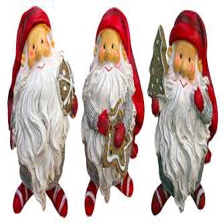

Model prediction 1, hence Santa


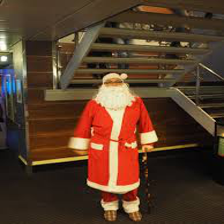

Model prediction 1, hence Santa


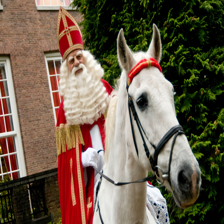

Model prediction 0, hence Not Santa


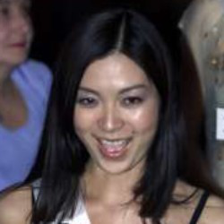

Model prediction 0, hence Not Santa


In [19]:
# Model Performance
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img.resize((224,224)))
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    if pred == 1:
        print(f"Model prediction {pred}, hence Santa")
    else:
        print(f"Model prediction {pred}, hence Not Santa")

    print("========================================================")

In [21]:
pip install modeci_mdf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.5/269.5 KB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

**PYTORCH TO MDF MODEL CREATING.JSON FILE**

In [22]:
import torchvision.models as models

import torch
from modeci_mdf.interfaces.pytorch import pytorch_to_mdf

resnet18 = models.resnet18(pretrained=False)


def main():
    # changed import call
    from modeci_mdf.execution_engine import EvaluableGraph

    # Create some test inputs for the model
    x = torch.rand((5, 3, 224, 224))

    # Turn on eval mode for model to get rid of any randomization due to things like BatchNorm or Dropout
    resnet18.eval()

    # Run the model once to get some ground truth output (from PyTorch)
    # with torch.no_grad():
    output = resnet18(x).detach().numpy()
    # print(output)

    # Convert to MDF
    mdf_model, params_dict = pytorch_to_mdf(
        model=resnet18,
        args=(x),
        trace=True,
    )
    # Get the graph
    mdf_graph = mdf_model.graphs[0]
    # Output the model to JSON
    mdf_model.to_json_file("resnet.json")


if __name__ == "__main__":
    main()


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/modeci_mdf/interfaces/pytorch/importer.py:517: FutureWarning: 'torch.onnx.symbolic_helper._set_opset_version' is deprecated in version 1.13 and will be removed in version 1.14. Please remove its usage and avoid setting internal variables directly.
  _set_opset_version(modeci_onnx_opset_version)
/usr/local/lib/python3.9/dist-packages/modeci_mdf/interfaces/pytorch/importer.py:526: FutureWarning: 'torch.onnx.symbolic_helper._set_opset_version' is deprec

In [23]:
def image_loader(loader, image):
    image = loader(image).float()
    image = image.clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [24]:
#using a pretrained model
sample_model = models.mobilenet_v3_large(pretrained=True)

#evaluating to get rid of randomization like dropout and batch-normalization
sample_model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [25]:
image_path = "/content/is that santa/test/santa/1.Santa.jpg"
input_image = Image.open(image_path)

In [31]:
from torchvision import transforms
from torchvision.io import read_image
import torch
from PIL import Image
import torchvision.models as models
import numpy as np

from modeci_mdf.interfaces.pytorch import pytorch_to_mdf
from modeci_mdf.execution_engine import EvaluableGraph

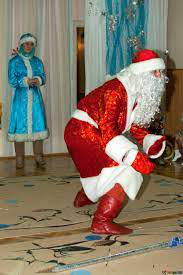

In [26]:
display(input_image)

In [29]:
mdf_model, params_dict = pytorch_to_mdf(
        model=sample_model,
        args=input,
        trace=True,
    )

**MDF GRAPH FORMATION**

Converting MDF graph: MobileNetV3Graph to graphviz (level: 1, format: png)
    Node: Conv_499
    Node: HardSwish_315
    Node: Conv_502
    Node: Relu_318
    Node: Conv_505
    Node: Add_321
    Node: Conv_508
    Node: Relu_324
    Node: Conv_511
    Node: Relu_327
    Node: Conv_514
    Node: Conv_517
    Node: Relu_332
    Node: Conv_520
    Node: Relu_335
    Node: Conv_523
    Node: Add_338
    Node: Conv_526
    Node: Relu_341
    Node: Conv_529
    Node: Relu_344
    Node: GlobalAveragePool_345
    Node: Conv_346
    Node: Relu_347
    Node: Conv_348
    Node: HardSigmoid_349
    Node: Mul_350
    Node: Conv_532
    Node: Conv_535
    Node: Relu_355
    Node: Conv_538
    Node: Relu_358
    Node: GlobalAveragePool_359
    Node: Conv_360
    Node: Relu_361
    Node: Conv_362
    Node: HardSigmoid_363
    Node: Mul_364
    Node: Conv_541
    Node: Add_367
    Node: Conv_544
    Node: Relu_370
    Node: Conv_547
    Node: Relu_373
    Node: GlobalAveragePool_374
    Node: Conv_37

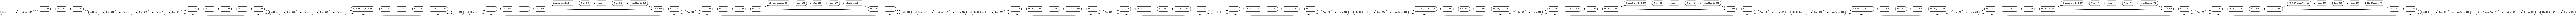

In [33]:
mdf_model.to_graph_image(
    engine="dot",
    output_format="png",
    view_on_render=False,
    level=1,
    filename_root="example",
    only_warn_on_fail=True,
    is_horizontal = True
)
from IPython.display import Image
Image(filename="example1.png")